# US Drinking Water Health-Based Quality Violations

The US Environmental Progection Agency EPA is publishing datasets about US water systems through its [envirofacts](https://www3.epa.gov/enviro/) platform. Information about safe drinking water is stored in SDWIS, the EPA's Safe Drinking Water Information System. The [SDWIS](https://www.epa.gov/enviro/sdwis-model) consists of several tables, that can be joined through unique IDs.   

The types of violations collected by the EPA are diverse, e.g also procedural violations, but I will concentrate on health-based violations, that are more interesting to me.  

In this analysis, I will explore the health-based violations of drinking water quality and try to answer the following questions:

1. How many health-based drinking water violations happen per year?
2. How many water system are affected by those violations?
3. How many people are concernded by those violations?

[... say why the datasets and my questions are relevant/important...]

In [3]:
# set up the environment:

import pandas as pd
import numpy as np
import requests # to read the data from the REST API of EPA Envirofacts
import csv # needed as data accessed through the REST API are .csv (other possibilities are .xml or .xls)

import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt # to handle the dates in the dataset more easily

import seaborn as sns # I want to try seaborn for plotting. It looks to combine well with pandas.
sns.set(style="ticks", palette="colorblind", font_scale=2) # set the style of plot I want. 

## Health-Based Violations

One table - _VIOLATIONS_ - contains all the violations. According to the EPA, violations are detected by assessment of sample results or reviews (including on site visits). Examples of violations are Maximum Contaminant Level (MCL) violations, failure to replace lead service lines, treatment technique violations, procedural violations... I access the data through [Envirofacts RESTful API](https://www.epa.gov/enviro/web-services). I select only health-based violations.  

In [13]:
# read data: (! takes 3min)
CSV_URL = 'http://iaspub.epa.gov/enviro/efservice/VIOLATION/IS_HEALTH_BASED_IND/Y/ROWS/0:300000/CSV'
# notes on the API:
#     - VIOLATION = table
#     - IS_HEALTH_BASED_IND/Y ==> select only health-based violations
#     - ROWS/0:300000 ==> the default is to extract to first 10'000 rows. I want all rows, so i use a larger number

with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    violations = list(cr)
    
# create a data frame with the data:
violations = pd.DataFrame(violations)
new_header = violations.iloc[0] # grab the first row for the header
new_header = new_header.str.split('.').str[1] # we remove the redundant table name (VIOLATION) in column names
violations = violations[1:] # take the data less the header row
violations.columns = new_header # set the header row as the df header
# we remove the last column of null, that is an artifact of the extraction:
violations = violations.dropna(axis = 1, how='all') # axis = 1 to specify that we talk about the columns

In [14]:
print(violations.shape)
violations.head()
# violations.IS_HEALTH_BASED_IND.value_counts() # a check.

(249535, 34)


,PWSID,VIOLATION_ID,FACILITY_ID,POPULATION_SERVED_COUNT,NPM_CANDIDATE,PWS_ACTIVITY_CODE,PWS_DEACTIVATION_DATE,PRIMARY_SOURCE_CODE,POP_CAT_5_CODE,PRIMACY_AGENCY_CODE,...,LATEST_ENFORCEMENT_ID,RTC_ENFORCEMENT_ID,RTC_DATE,PUBLIC_NOTIFICATION_TIER,ORIGINATOR_CODE,SAMPLE_RESULT_ID,CORRECTIVE_ACTION_ID,RULE_CODE,RULE_GROUP_CODE,RULE_FAMILY_CODE
1,MS0490010,7202512,,5043,N,A,,GW,3,MS,...,7203414,7203415,10-AUG-11,2,S,,,110,100,110
2,OH1238312,7925501,,78,N,A,,GW,1,OH,...,8111408,8111408,12-FEB-08,2,S,,,350,300,350
3,OH1238312,7925697,,78,N,A,,GW,1,OH,...,8111408,8111408,12-FEB-08,2,S,,,350,300,350
4,OH1238312,7925298,,78,N,A,,GW,1,OH,...,8111408,8111408,12-FEB-08,2,S,,,350,300,350
5,OH1238312,7925403,,78,N,A,,GW,1,OH,...,8111408,8111408,12-FEB-08,2,S,,,350,300,350


In [15]:
# violations.describe()
violations.columns.values

array(['PWSID', 'VIOLATION_ID', 'FACILITY_ID', 'POPULATION_SERVED_COUNT',
       'NPM_CANDIDATE', 'PWS_ACTIVITY_CODE', 'PWS_DEACTIVATION_DATE',
       'PRIMARY_SOURCE_CODE', 'POP_CAT_5_CODE', 'PRIMACY_AGENCY_CODE',
       'EPA_REGION', 'PWS_TYPE_CODE', 'VIOLATION_CODE',
       'VIOLATION_CATEGORY_CODE', 'IS_HEALTH_BASED_IND',
       'CONTAMINANT_CODE', 'COMPLIANCE_STATUS_CODE', 'VIOL_MEASURE',
       'UNIT_OF_MEASURE', 'STATE_MCL', 'IS_MAJOR_VIOL_IND',
       'SEVERITY_IND_CNT', 'COMPL_PER_BEGIN_DATE', 'COMPL_PER_END_DATE',
       'LATEST_ENFORCEMENT_ID', 'RTC_ENFORCEMENT_ID', 'RTC_DATE',
       'PUBLIC_NOTIFICATION_TIER', 'ORIGINATOR_CODE', 'SAMPLE_RESULT_ID',
       'CORRECTIVE_ACTION_ID', 'RULE_CODE', 'RULE_GROUP_CODE',
       'RULE_FAMILY_CODE'], dtype=object)

In [21]:
# violations.dtypes # a check. (later we convert COMPL_PER_BEGIN_DATE to the datetime type)

In [23]:
# On the contrary to what was expected, the VIOLATION_ID is not a unique identifier:
# print(len(violations['PWSID']))
# print(len(set(violations['PWSID'])))
print("Number of rows in dataset: " + str(len(violations['VIOLATION_ID'])))
print("Number of distinct violations IDs: " + str(len(set(violations['VIOLATION_ID']))))
# print(len(violations['FACILITY_ID']))
# print(len(set(violations['FACILITY_ID'])))

# print(violations.set_index(list(violations)).index.is_unique) # but there are no repeated rows.
# print(violations.set_index(list(violations)[0:2]).index.is_unique) # combine system, violations and facilities to have uniques

# ==> the same violation can be present in several water system (PWSID) or facility (FACILITY_ID). 

# Thus, I create a unique identifier for the dataset:
violations['my_violations_ID'] = violations['PWSID'] + "_" + violations['VIOLATION_ID'] + "_" + violations['FACILITY_ID']
# It is not sure that I will use it in this analysis, but it might be useful in the future, 
# if I pursue the analysis 


Number of rows in dataset: 249534
Number of distinct violations IDs: 145410


## How many Health-Based Drinking Water Violations Happen per Year?

The dataset of violations contains 249535 observations, but the VIOLATION_ID contains only 145411 unique values. After inspection, I found that the reason is that the same violation can be present in several water systems (PWSID) or facilities (FACILITY_ID). I will look at the number of unique violations, thus look at how theses 145411 violations are distributed over the years in the dataset.  

The dataset contains violations from year 1978 to 2018 (and a few in 2064, that I removed as they are probably an error). We observe that __the number of detected - and reported - violations increased greatly in recent years, particularly after 2008__. As from 2009, the number of violations observed per year varies between around 18'000 to 20'000.  

The dataset contains very few violations detected before 2007. __This is more likely to reflect the introduction of new regulations than a real increase in the number of violations__. However, as the population of the US also increased in parallel (or new industries, or an increase of the use of hydraulic fracking, see [EPA's Study](https://cfpub.epa.gov/ncea/hfstudy/recordisplay.cfm?deid=332990)), it could be worth digging more into this question to try to disentangle the effects.   

The drop in violations detection from 2016 to 2018 is probably due to the fact that not all analyses are finished or were entered in the system yet. Alternatively, it could also be due to the different priorities of the Trump administration regarding clean water (e.g. [suspension of the clean water rule](https://en.wikipedia.org/wiki/Clean_Water_Rule)). It is too early for me to conclude on that matter (witout contacting the EPA directly).    

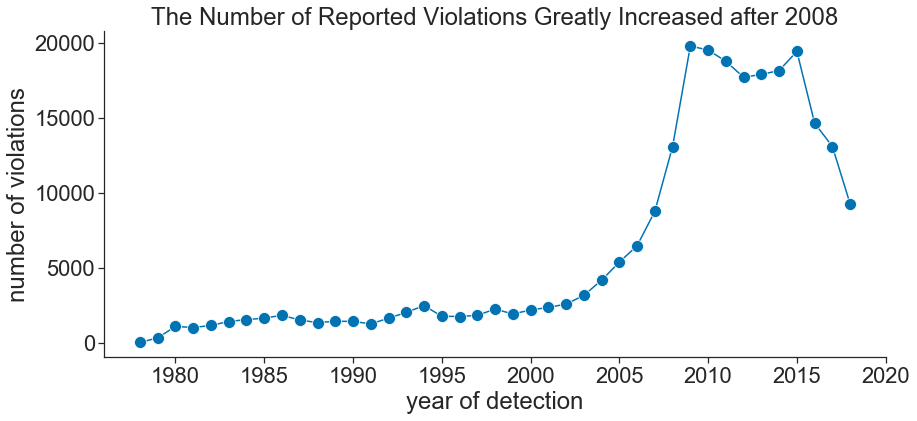

In [24]:
# COMPL_PER_BEGIN_DATE: represents the beginning of a period of time when 
# a public water system was in violation of a primary drinking water regulation.
# we convert the date to a datetime type, so it will be easier to work with:
violations['COMPL_PER_BEGIN_DATE'] =  pd.to_datetime(violations['COMPL_PER_BEGIN_DATE']) # 
# add a column with the year only (start year of the violation):
violations['start_year'] = violations['COMPL_PER_BEGIN_DATE'].dt.year

# the data contains some violations with start_year in the future (we have some in 2064)
violations = violations.loc[violations['start_year'] <= 2018]

# we are now interested only in the violations and the year when they occur. 
# so I will create a dataset with violations only (i do this because VIOLATION_ID are not unique)
unique_violations = violations[['VIOLATION_ID', 'start_year']]

# and then we group by year to count the violations:
unique_violations_per_year = unique_violations.groupby(['start_year'], as_index=False).count()

plt.figure(figsize=(14, 6))
p = sns.lineplot(x="start_year", y="VIOLATION_ID",
             marker="o", markersize=12,
             data=unique_violations_per_year)
# p.add_legend(title="Meal")
p.set(xlabel='year of detection', ylabel='number of violations', 
      title = 'The Number of Reported Violations Greatly Increased after 2008')
#      xticks=range(1978,2019,5))
sns.despine()
plt.show()


## How many water system are affected by those violations?

We saw that around 20'000 yearly drinking water violations were observed in the recent years, but how are those violations distributed over the water systems? Are those violations widespread or restricted to a few "bad performing" water systems? I will try to quantify the distribution of these violations among the water systems.  



In [ ]:
# for this, I need to read another table that stores all the water systems:

# read the data from the REST API of EPA Envirofacts, for the water system table.
CSV_URL = 'http://iaspub.epa.gov/enviro/efservice/WATER_SYSTEM/ROWS/0:500000/CSV'

with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    WATER_SYSTEM = list(cr)

# create a data frame with the data:
WATER_SYSTEM = pd.DataFrame(WATER_SYSTEM)
new_header = WATER_SYSTEM.iloc[0] # grab the first row for the header
new_header = new_header.str.split('.').str[1] # we remove the redundant table name (WATER_SYSTEM) in column names
WATER_SYSTEM = WATER_SYSTEM[1:] # take the data less the header row
WATER_SYSTEM.columns = new_header # set the header row as the df header

# we remove the last column of null, that is an artifact of the extraction:
WATER_SYSTEM = WATER_SYSTEM.iloc[:, 0:len(WATER_SYSTEM.columns)-1] # ATTENTION : run this code only once or find a way to access a nan column with .loc...

# we note that 2 columns extracted are not in the EPA data dictionary: CITIES_SERVED, NPM_CANDIDATE ?


In [ ]:
# np.shape(WATER_SYSTEM)
print("There are " + str(len(WATER_SYSTEM['PWSID'])) + " distinct water systems in the dataset.")
# print(len(set(WATER_SYSTEM['PWSID']))) PWSID is a unique ID


Because not all the water systems in the dataset are currently active, or were active at the year of the violation, and because the quantity of data about the violations varies over the years, I choose to focus on one single year. __I will continue the analysis with the last year were the data seems to be complete: 2016.__ This leaves us with 7233 water systems, in which 14648 health-based violations were observed.  

In [1]:
# we convert the deactivation date to the datetime type:
WATER_SYSTEM['PWS_DEACTIVATION_DATE'] =  pd.to_datetime(WATER_SYSTEM['PWS_DEACTIVATION_DATE']) 
set(WATER_SYSTEM['PWS_DEACTIVATION_DATE'])

# we filter to keep only the water systems that were active (not deactivated) in 2016
ws_2016 = WATER_SYSTEM[WATER_SYSTEM['PWS_DEACTIVATION_DATE'] >= '2017-01-01 00:00:00']
np.shape(ws_2016)

NameError: name 'pd' is not defined

In [11]:
# we create a dataframe with the violations observed in 2016:
violations_2016 = violations[violations['start_year'] == 2016]
np.shape(violations_2016)

(14648, 36)

... to be continued:  

        * compute intersection of ws_2016.PWSID and violations_2016.PWSID
        * compute percentage of affected water system
        * plot distribution of number of violations per PWSID in ws_2016 (barplot or histogram)

In [ ]:
ws_2016, violations_2016

# s1 = pd.merge(df1, df2, how='inner', on=['user_id'])

## How many people are concernded by those violations?
look at: POPULATION_SERVED_COUNT: Water system’s estimate of the number of people served by the system. ==> pop affected by the violations. 

## Future Analyses that Could Be Done
[... develop more the following points: ...]
* try a chloropeth map of the US? https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d  
* run a statistical - or litterature? - analysis to explain the increase of the number of violations and disentangle the different effects.
* try to predict violations: which water system are more likely to be subject to a health-based violation? It would be valuable information for the EPA or the owners of the water systems.
* link the dataset with other datesets. For instance one could link this data to weather datasets (we have the coordinates of the water systems) to assess the influence of the weather on the occurrences of violations (and potentially improve the predictions).  ==> noaa.gov
